In [9]:
import numpy as np
import scipy.linalg as la
from scipy.linalg import expm
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
from evolutions import *
from distances import *
from tqdm import tqdm
import os
from tqdm import tqdm
from threading import Lock
import pickle
from scipy.stats import bootstrap
import matplotlib.pyplot as plt




In [2]:
#1D Hamiltonian definitions
X = np.array([[0.,1.],[1.,0.]],dtype=complex)
Y = np.array([[0.,-1.j],[1.j,0.]],dtype=complex)
Z = np.array([[1.,0.],[0.,-1.]],dtype=complex)
I = np.array([[1.,0.],[0.,1.]],dtype=complex)


def define1D_Hterm(nsites,site,pauli,twosites=False):
    #calculates matrix of a single Hamiltonian term with spectral norm=1
    #nsites: number of spin 1/2 sites
    #site: site index of the term Hi
    #pauli: can be X Y Z for site i
    #twosites: False=> site i, True=> site i and i+1 
    op_list = [I] * nsites
    if not twosites:
        op_list[site]= pauli
    else:
        op_list[site]= pauli
        op_list[(site+1)%nsites] = pauli

    result = op_list[0]
    for op in op_list[1:]:
        result = np.kron(result, op)
    return result

def define1D_Hamiltonian(nsites,terms,coefficients,d=2):
    #dictionary containing all hamiltonian information and initial state
    Hdict=dict()
    Hdict["nsites"]=nsites
    Hdict["local_dim"]=d
    Hdict["Hilbert_dim"]=d**nsites
    Hdict["terms"]=terms
    Hdict["coefficients"]=np.array(coefficients)
    Hdict["lambda"]=sum(coefficients)
    Hdict["probabilities"]=np.abs(Hdict["coefficients"]/Hdict["lambda"])
    Hdict["weighted_terms"]=[hi*Hi for hi,Hi in zip(coefficients,terms)]
    Hdict["Hamiltonian"]=sum(Hdict["weighted_terms"])
    
    # initial updownupdown state
    assert d==2 # if later we want to do qtrits ?
    binary_str = ''.join(['0' if i % 2 == 0 else '1' for i in range(nsites)])
    state_index = int(binary_str, 2)
    state_vector = np.zeros(2**nsites, dtype=complex)
    state_vector[state_index] = 1
    Hdict["initial_state"]=state_vector
    return Hdict

def Ising1D_Hamiltonian(nsites,J=1,h=1,periodic=False):

    if periodic: 
        p=0 
    else: 
        p=1

    Jterms= [define1D_Hterm(nsites,i,Z,twosites=True) for i in range(nsites-p)]
    hterms= [define1D_Hterm(nsites,i,X) for i in range(nsites)]
    Jcoefs= [-J]*len(Jterms)
    hcoefs= [-h]*len(hterms)
    Hdict=  define1D_Hamiltonian(nsites,Jterms+hterms,Jcoefs+hcoefs)
    Hdict["name"]= "Ising1D"

    return Hdict



In [4]:
# Compute multiple evolutions

def equiv_nsamples_list(Hdict,nsteps_list):
    nterms=len(Hdict["terms"])
    return [nterms* nsteps for nsteps in nsteps_list]

def compute_exact_evolutions(Hdict,total_time_list,initial_state=None):
    exactstates=np.zeros((len(total_time_list),Hdict["Hilbert_dim"],Hdict["Hilbert_dim"]),dtype=complex)
    for total_time_idx,total_time in enumerate(total_time_list):
        exactstate = evolve_exact(Hdict,total_time,initial_state)
        exactstates[total_time_idx] = np.outer(exactstate,exactstate.conj())

    return exactstates

def compute_Trotter_evolutions(Hdict,total_time_list,nsteps_list,initial_state=None):
    # total times list x nsteps list x hdim x hdim
    Trstates=np.zeros((len(total_time_list),len(nsteps_list),Hdict["Hilbert_dim"],Hdict["Hilbert_dim"]),dtype=complex)
    for total_time_idx,total_time in enumerate(total_time_list):
        for nsteps_idx,nsteps in enumerate(nsteps_list):
            Trstate=evolve_Trotter(Hdict,total_time,nsteps,initial_state)
            Trstates[total_time_idx,nsteps_idx]=np.outer(Trstate,Trstate.conj())

    return Trstates


def compute_Qdrift_evolutions(Hdict, total_time_list, nsamples_list, ntrajs, initial_state=None, log_path="compute_Qdrift_evolutions.log", save_path="Qdrift_evolutions.pkl", save_progress_flag=True,save_freq=100):
    # total times list x nsamples list x trajectories x hdim x hdim
    Qstates = np.zeros((len(total_time_list), len(nsamples_list), ntrajs, Hdict["Hilbert_dim"],Hdict["Hilbert_dim"]), dtype=complex)
    
    # Lock for thread-safe saving/loading
    lock = Lock()
    
    # Helper function to verify Hdict with saved file:
    def compare_Hdict(dict1,dict2):
        return (dict1["name"]==dict2["name"] and dict1["Hilbert_dim"]==dict2["Hilbert_dim"] and np.array_equal(dict1["coefficients"],dict2["coefficients"]) and np.array_equal(dict1["initial_state"],dict2["initial_state"]))

    # Check if there is a saved file and resume
    if os.path.exists(save_path) and save_progress_flag:
        print("Resuming from saved file...")
        with lock:
            with open(save_path, 'rb') as f:
                data = pickle.load(f)
                Qstates = data['Qstates']
                processed_indices = set(data['processed_indices'])  # Convert back to set

                saved_Hdict = data['Hdict']
                saved_total_time_list = data['total_time_list']
                saved_nsamples_list = data['nsamples_list']
                saved_ntrajs = data['ntrajs']
                # Verify if parameters match
                assert compare_Hdict(Hdict,saved_Hdict), "Mismatch in Hdict"
                assert total_time_list == saved_total_time_list, "Mismatch in total_time_list"
                assert nsamples_list == saved_nsamples_list, "Mismatch in nsamples_list"
                assert ntrajs == saved_ntrajs, "Mismatch in ntrajs"
                
    else:
        processed_indices = set()

    # Helper function to save progress
    def save_progress():
        if save_progress_flag:  # Only save if the flag is True
            with lock:
                with open(save_path, 'wb') as f:
                    pickle.dump({
                        'Qstates': Qstates,
                        'processed_indices': list(processed_indices),
                        'Hdict': Hdict,
                        'total_time_list': total_time_list,
                        'nsamples_list': nsamples_list,
                        'ntrajs': ntrajs
                    }, f)
                print("Progress saved.")

    # Start logging the progress
    with open(log_path, "w") as f:
        with tqdm(total=len(total_time_list) * len(nsamples_list), file=f, desc="compute_Qdrift_evolutions") as progress_bar:
            with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
                futures = []
                
                for total_time_idx, total_time in enumerate(total_time_list):
                    for nsamples_idx, nsamples in enumerate(nsamples_list):
                        # Skip already processed (total_time_idx, nsamples_idx)
                        if (total_time_idx, nsamples_idx) in processed_indices:
                            with lock:
                                progress_bar.update(1)
                            continue
                        
                        # Submit the task for unprocessed indices
                        futures.append(executor.submit(
                            evolve_Qdrift_trajectories, Hdict, total_time, nsamples, ntrajs, initial_state,
                            (total_time_idx, nsamples_idx)
                        ))

                # Process the results as they finish
                for future in as_completed(futures):
                    evolved_trajs, idx = future.result()
                    Qstates[idx[0], idx[1]] = evolved_trajs
                    
                    # Update progress bar and save state periodically
                    progress_bar.update(1)
                    
                    # Update processed indices and save progress
                    processed_indices.add(idx)
                    if progress_bar.n % save_freq == 0 and save_progress_flag:  # Save progress every freq updates, only if saving is enabled
                        save_progress()
                    
            # Final save when the loop finishes
            save_progress()
    
    print("Done")
    return Qstates

"""def compute_Qdrift_evolutions(Hdict,total_time_list,nsamples_list,ntrajs,initial_state=None):
    # total times list x nsamples list x trajectories x 2**N
    Qstates=np.zeros((len(total_time_list),len(nsamples_list),ntrajs,Hdict["Hilbert_dim"]),dtype=complex)
    with open("compute_Qdrift_evolutions.log","w") as f:
        with tqdm(total=len(total_time_list)*len(nsamples_list),file=f) as progress_bar:
            with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
                futures = []
                for total_time_idx, total_time in enumerate(total_time_list):
                    for nsamples_idx, nsamples in enumerate(nsamples_list):
                        #Qstates[total_time_idx,nsamples_idx]=evolve_Qdrift_trajectories(Hdict,total_time,nsamples,ntrajs,initial_state)
                        futures.append(executor.submit(evolve_Qdrift_trajectories,Hdict,total_time,nsamples,ntrajs,initial_state,(total_time_idx,nsamples_idx)))

                for future in as_completed(futures):
                    evolved_trajs,idx=future.result()
                    Qstates[idx[0],idx[1]]=evolved_trajs
                    progress_bar.update(1)
            return Qstates"""

'def compute_Qdrift_evolutions(Hdict,total_time_list,nsamples_list,ntrajs,initial_state=None):\n    # total times list x nsamples list x trajectories x 2**N\n    Qstates=np.zeros((len(total_time_list),len(nsamples_list),ntrajs,Hdict["Hilbert_dim"]),dtype=complex)\n    with open("compute_Qdrift_evolutions.log","w") as f:\n        with tqdm(total=len(total_time_list)*len(nsamples_list),file=f) as progress_bar:\n            with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:\n                futures = []\n                for total_time_idx, total_time in enumerate(total_time_list):\n                    for nsamples_idx, nsamples in enumerate(nsamples_list):\n                        #Qstates[total_time_idx,nsamples_idx]=evolve_Qdrift_trajectories(Hdict,total_time,nsamples,ntrajs,initial_state)\n                        futures.append(executor.submit(evolve_Qdrift_trajectories,Hdict,total_time,nsamples,ntrajs,initial_state,(total_time_idx,nsamples_idx)))\n\n       

In [6]:


def Qdrift_distance_stats(exactdensities,Qdensities,num_mix,M_list,seed=2,purify=False,distance=trace_distance,**kwargs):
    #Qdensities: times x nsteps x ntrajs x hdim x hdim
    distances=np.zeros((Qdensities.shape[:2])+(len(M_list),3)) # distances: times x steps x Ms x 3

    np.random.seed(seed)
    rng = np.random.default_rng(seed)
    with tqdm(total= np.prod(distances.shape[:-1])*num_mix, desc="Qdrift_distance_stats") as progress_bar:
        with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
            futures=[]
            for idx in np.ndindex(distances.shape[:3]):
                tmp_array= []

                for _ in range(num_mix):
                    futures.append(executor.submit(mix_and_compare,Qdensities[idx[:2]],M_list[idx[2]],exactdensities[idx[0]],purify,distance,**kwargs))

                for future in as_completed(futures):
                    tmp_array.append(future.result())
                    progress_bar.update(1)
                    
                stats = bootstrap((tmp_array,), np.mean, confidence_level=0.9, random_state=rng)
                distances[idx]=[np.mean(tmp_array), stats.confidence_interval.low, stats.confidence_interval.high]
    return distances

def Trotter_distances(exactdensities,Trdensities,distance=trace_distance,**kwargs):
    distances=np.zeros((Trdensities.shape[:2]))
    for idx in np.ndindex(Trdensities.shape[:2]):
        distances[idx]=distance(Trdensities[idx],exactdensities[idx[0]],**kwargs)
    return distances




In [8]:
ising1D=Ising1D_Hamiltonian(2)
"""
total_time_list = [0.1,0.5,1.0,1.5,2.0]
nsteps_list = [10,20,40,80,160,240,320,400,480,560,640]  #  total gates used = number of Hterms x nsteps
nsamples_list=equiv_nsamples_list(ising1D,nsteps_list)   #  total gates used = nsamples (plot with these values)
ntraj=1000000
num_mix=10000
M=[100,1000,10000,50000]
"""
total_time_list = [0.1,0.5,1.0]
nsteps_list = [10,20,40,80,160,240]  #  total gates used = number of Hterms x nsteps
nsamples_list=equiv_nsamples_list(ising1D,nsteps_list)   #  total gates used = nsamples (plot with these values)
ntraj=5000
num_mix=100
M_list=[1000,2000,3000,5000]
 
Qstates=compute_Qdrift_evolutions(ising1D,total_time_list,nsamples_list,ntraj,save_path="1KQdrift_evolutions.pkl")
Trstates=compute_Trotter_evolutions(ising1D,total_time_list,nsteps_list)
exactstates=compute_exact_evolutions(ising1D,total_time_list)
#Qdensitymatrices=states_to_densitymatrices(Qstates)
Trdensitymatrices=states_to_densitymatrices(Trstates)
exactdensitymatrices=states_to_densitymatrices(exactstates)





Resuming from saved file...
Progress saved.
Done


100%|██████████| 5/5 [00:00<00:00, 11.25it/s]


In [ ]:
Qtracedist.shape

(3, 11, 4, 3)

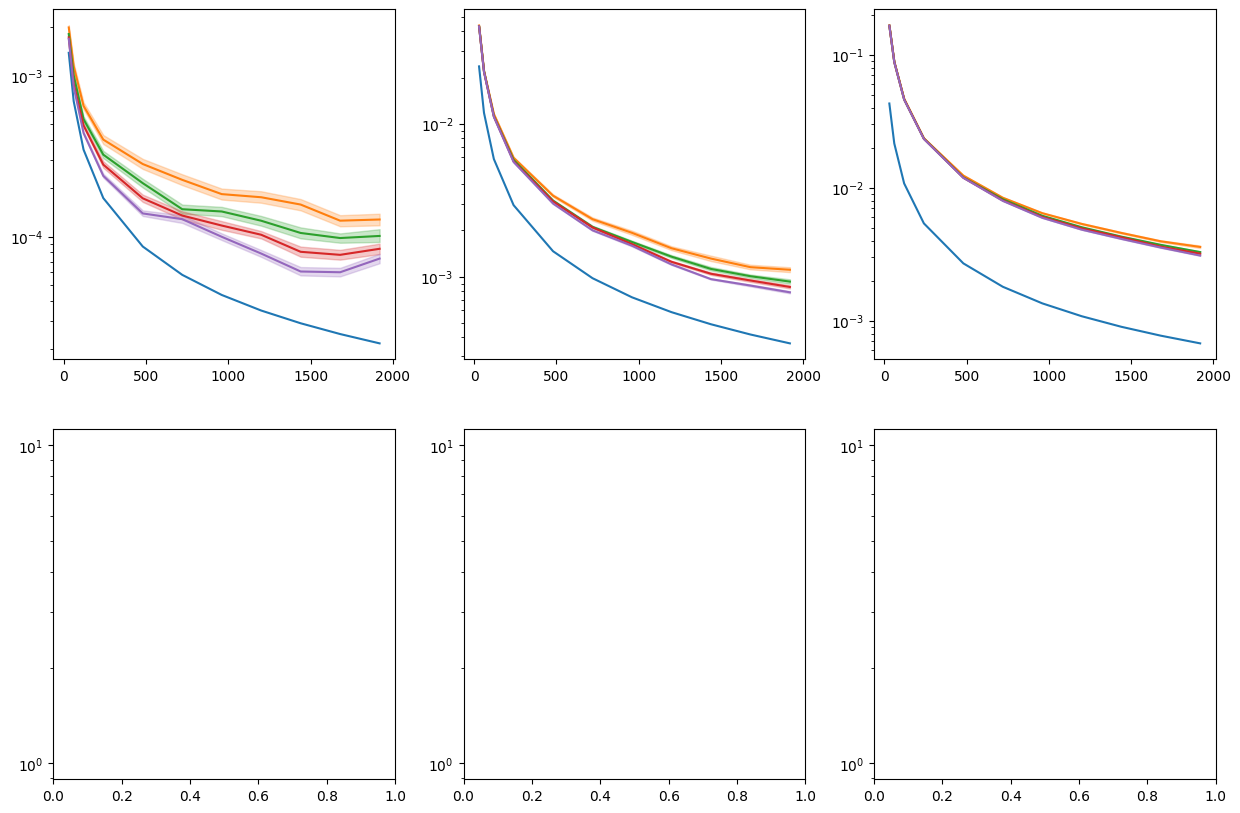

In [ ]:
#Qtracedist= Qdrift_distance_stats(exactdensitymatrices,Qdensitymatrices,num_mix,M_list)
#Qtracedistpure= Qdrift_distance_stats(exactdensitymatrices,Qdensitymatrices,num_mix,M_list,purify=True)
#Trtracedist= Trotter_distances(exactdensitymatrices,Trdensitymatrices)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))  
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for tt in range(3):
    ax1=axs[0,tt]
    ax2=axs[1,tt]
    ax1.set_yscale("log") 
    ax2.set_yscale("log") 

    ax1.plot(nsamples_list, Trtracedist[tt])
    for midx,M in enumerate(M_list):
        ax1.plot(nsamples_list, Qtracedist[tt,:,midx,0])
        low = Qtracedist[tt,:,midx,1]
        high = Qtracedist[tt,:,midx,2]
        ax1.fill_between(nsamples_list, high, low, color=colors[midx+1], alpha=0.25)


NameError: name 'TF1' is not defined

IndexError: index 3195 is out of bounds for axis 0 with size 2